In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import sys
import os
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage,leaves_list
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import hamming, squareform
from scipy.spatial.distance import pdist, jaccard

BLOOD_MICROBIOME_PATH = '/home/groups/dpwall/briannac/blood_microbiome/'
fig_dir=BLOOD_MICROBIOME_PATH + 'results/abundances/'

sys.path.append('/home/groups/dpwall/briannac/blood_microbiome/src')
bam_mappings_file = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'

bacteria_file = BLOOD_MICROBIOME_PATH + 'data/kraken_align/bacteria_filtered_species.df' 
virus_file = BLOOD_MICROBIOME_PATH + 'data/kraken_align/virus_filtered_species.df' 

# Filter

## Load / format data

In [2]:
bam_mappings = pd.read_csv(bam_mappings_file, sep='\t', index_col=1)
df_bacteria = pd.read_pickle(bacteria_file)
df_virus  = pd.read_pickle(virus_file)

In [3]:
df_virus.index = [i[2] for i in df_virus.index]
df_bacteria.index = [i[2] for i in df_bacteria.index]
df_virus = df_virus.transpose()
df_bacteria = df_bacteria.transpose()

# Microbe Abundance Plots
## Virus

In [4]:
virus_abundant = df_virus.columns[np.argsort(df_virus.sum())[::-1]]
virus_prevalent = []#df_virus.columns[np.argsort((df_virus>0).sum())[::-1]][:25]
select_viruses = list(set(virus_abundant).union(set(virus_prevalent)))
len(select_viruses)

51

In [5]:
# Hacky way to make cylical color palette.
a=np.concatenate([[tuple(i) for i in sns.color_palette("husl", 34)[n::5]] for n in range(5)])
a = [tuple(i) for i in a]
palette = ['#%02x%02x%02x' % (int(i[0]*255), int(i[1]*255), int(i[2]*255)) for i in a]
hierarchy.set_link_color_palette(palette)

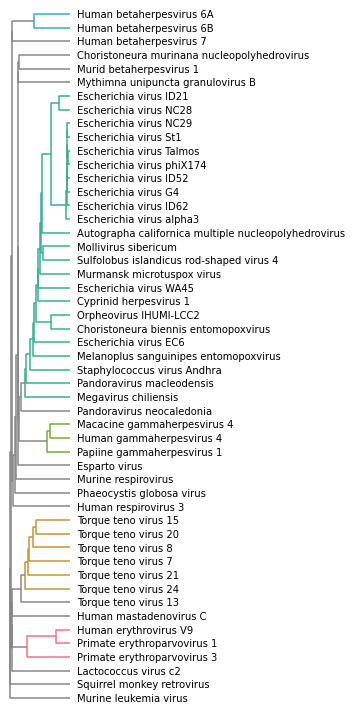

In [6]:
dists = 1-df_virus[select_viruses].corr('spearman')#pdist(df_bacteria.transpose(), 'braycurtis')
linkage_mat = linkage(squareform(dists))#, 'ward')
virus_order = df_virus[select_viruses].columns[leaves_list(linkage_mat)]
plt.figure(figsize=(5,10))
dn2 = dendrogram(linkage_mat, orientation='left', labels=select_viruses, color_threshold=0.8*np.max(linkage_mat[:,2]), get_leaves=True, above_threshold_color='#858585')
ax = plt.gca()
ax.tick_params(axis='y', which='major', labelsize=10)
plt.box(on=None)
plt.bbox_inches='tight'
plt.xticks([])
plt.tight_layout()
plt.savefig(fig_dir + 'virus_clusters_kraken.svg', transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

In [8]:
#for v in virus_order[::-1]: print("'%s',"%v)


In [13]:
### Hacky way to get colors right ###
# Viruses that don't belong to a cluster (bottom to top)
loners = [
'Human betaherpesvirus 7',
'Choristoneura murinana nucleopolyhedrovirus',
'Murid betaherpesvirus 1',
'Mythimna unipuncta granulovirus B',
'Pandoravirus neocaledonia',
'Esparto virus',
'Murine respirovirus',
'Phaeocystis globosa virus',
'Human respirovirus 3',
'Torque teno virus 13',
'Human mastadenovirus C',
'Lactococcus virus c2',
'Squirrel monkey retrovirus',
'Murine leukemia virus']

palette_dict = {p:i for i,p in enumerate(['#858585'] + palette)}
color_count = Counter([palette_dict[d] for d in dn2['color_list']])
color = np.array([0 for i in virus_order])
i_start = 0
for c in range(1,len(color_count)):
    while virus_order[i_start] in loners:
        i_start = i_start + 1
    i_end = i_start + color_count[c] + 1
    color[i_start:i_end] = c
    i_start = i_end
color_dict = {i:j for i,j in zip(virus_order, color)}

sns.set_palette(['#858585'] + palette)
df_melt = pd.melt(df_virus[virus_order[::-1]])
df_melt = df_melt[df_melt.value>0]
df_melt = df_melt[df_melt.value>0]
df_melt['color'] = [color_dict[v] for v in df_melt.variable]

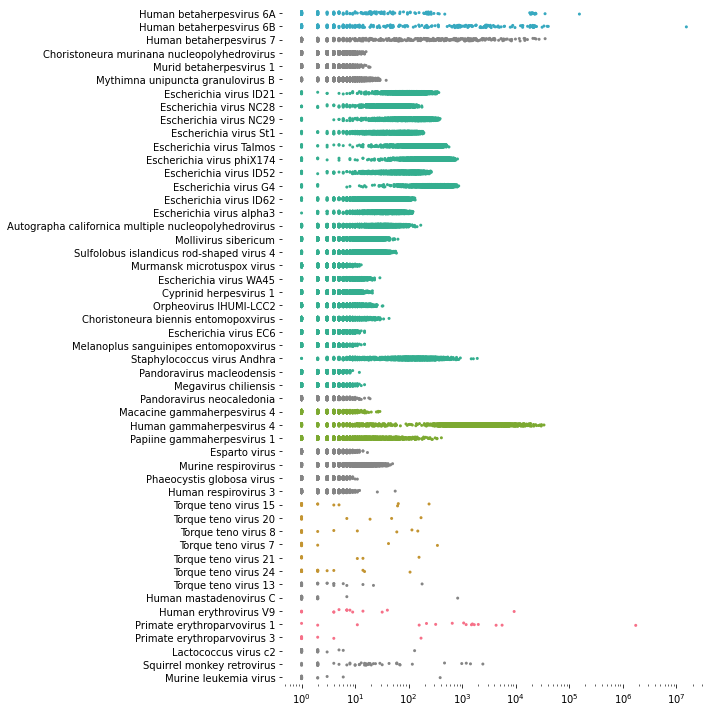

In [14]:
plt.figure(figsize=(10,10))
sns.stripplot(data=df_melt, y='variable', x='value', hue='color', jitter=.1, size=3)
plt.xscale('log')
plt.ylabel('')
plt.xlabel('')
ax = plt.gca()
ax.tick_params(axis='y', which='major', labelsize=10)
plt.box(on=None)
plt.legend().remove()
plt.tight_layout()
plt.savefig(fig_dir + 'virus_abundance_kraken.svg', transparent=True, bbox_inches='tight', format='png', dpi=500)

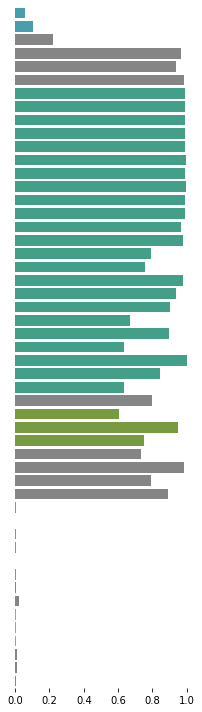

In [15]:
plt.figure(figsize=(3,10))
prevalence = pd.DataFrame((df_virus>0).mean(),columns=['prev'])
prevalence = prevalence.loc[virus_order[::-1]]
prevalence['microbe'] = prevalence.index
prevalence['color'] = [color_dict[v] for v in prevalence.microbe]
sns.barplot(data=prevalence, y='microbe', x='prev', hue='color', dodge=False)
plt.yticks([])
plt.ylabel('')
plt.xlabel('')
plt.legend().remove()
plt.box(on=None)
plt.tight_layout()
plt.savefig(fig_dir + 'virus_prevalence_kraken.svg', transparent=True, bbox_inches='tight', format='png', dpi=500)

# Bacteria

In [16]:
bacteria_abundant = df_bacteria.columns[np.argsort(df_bacteria.sum())[::-1]][:100]
bacteria_prevalent = []#df_bacteria.columns[np.argsort((df_bacteria>0).sum())[::-1]][:100]
select_bacteria = list(set(bacteria_abundant).union(set(bacteria_prevalent)))
len(select_bacteria)

100

In [10]:
dists = 1-df_bacteria[select_bacteria].corr('spearman')#pdist(df_bacteria.transpose(), 'braycurtis')
linkage_mat = linkage(dists)
bacteria_order = list(df_bacteria[select_bacteria].columns[leaves_list(linkage_mat)])

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


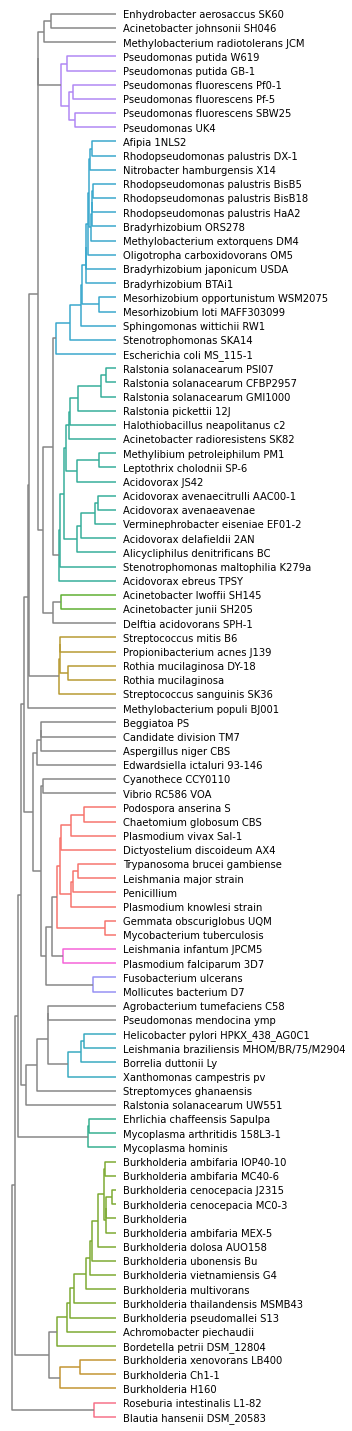

In [11]:
plt.figure(figsize=(5,20))
hierarchy.set_link_color_palette(palette)
dn2 = dendrogram(linkage_mat, orientation='left', labels=select_bacteria,color_threshold=0.6*np.max(linkage_mat[:,2]), above_threshold_color='#858585')
ax = plt.gca()
ax.tick_params(axis='y', which='major', labelsize=10)
plt.box(on=None)
plt.bbox_inches='tight'
plt.xticks([])
plt.tight_layout()
plt.savefig(fig_dir + 'bacteria_clusters.svg', transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

In [12]:
### Hacky way to get colors right ###
#for v in bacteria_order[::-1]: print("'%s',"%v)
# Bacteria that don't belong to a cluster (bottom to top)
loners = [
'Delftia acidovorans SPH-1',
'Enhydrobacter aerosaccus SK60',
'Acinetobacter johnsonii SH046',
'Methylobacterium radiotolerans JCM',
'Methylobacterium populi BJ001',
'Beggiatoa PS',
'Candidate division TM7',
'Aspergillus niger CBS',
'Edwardsiella ictaluri 93-146',
'Cyanothece CCY0110',
'Vibrio RC586 VOA',
'Pseudomonas mendocina ymp',
'Agrobacterium tumefaciens C58',
'Streptomyces ghanaensis',
'Ralstonia solanacearum UW551',
]

palette_dict = {p:i for i,p in enumerate(['#858585'] + palette)}
color_count = Counter([palette_dict[d] for d in dn2['color_list']])
color = np.array([0 for i in bacteria_order])
i_start = 0
for c in range(1,len(color_count)):
    while bacteria_order[i_start] in loners:
        i_start = i_start + 1
    i_end = i_start + color_count[c] + 1
    color[i_start:i_end] = c
    i_start = i_end
color_dict = {i:j for i,j in zip(bacteria_order, color)}

In [13]:
sns.set_palette(['#858585'] + palette)
df_melt = pd.melt(df_bacteria[bacteria_order[::-1]])
df_melt = df_melt[df_melt.value>0]
df_melt['color'] = [color_dict[v] for v in df_melt.variable]

In [14]:
df_bacteria['Mycobacterium tuberculosis'].max()

18222

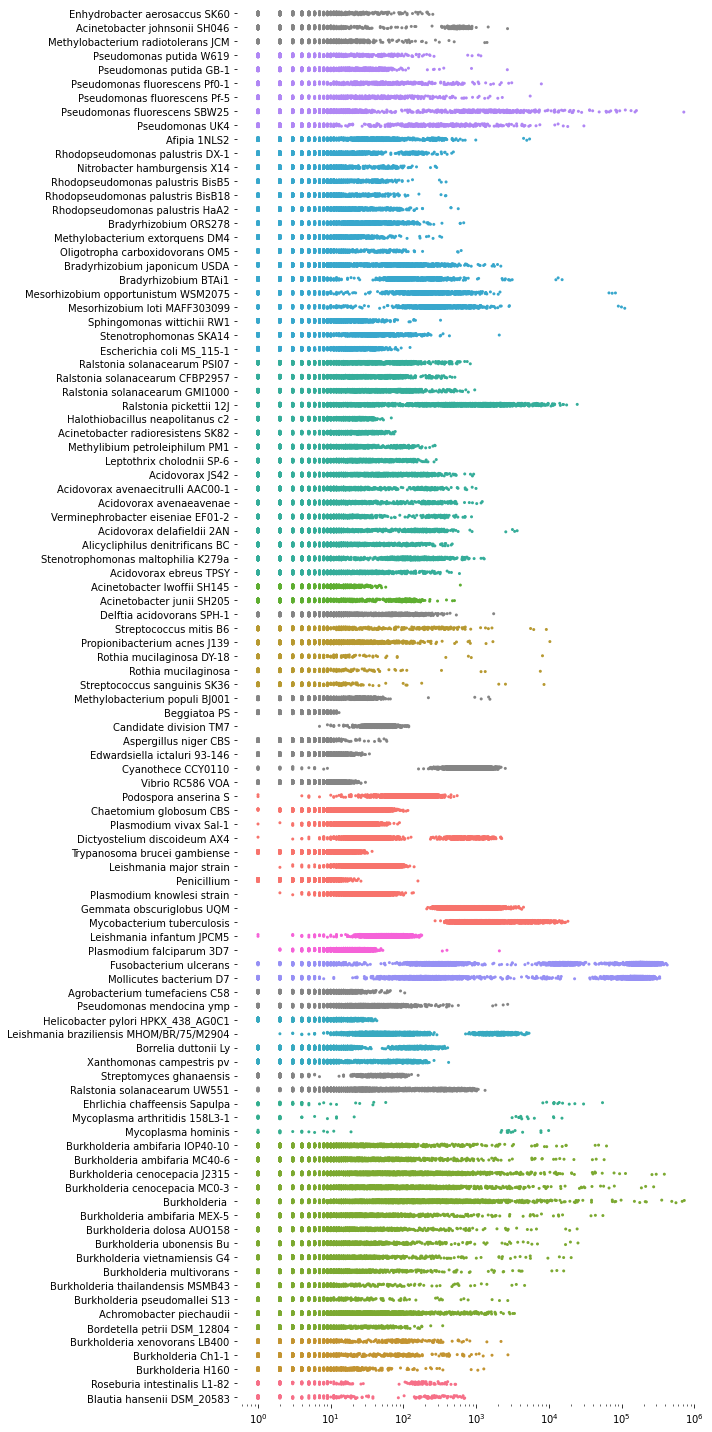

In [15]:
plt.figure(figsize=(10,20))
df_melt = pd.melt(df_bacteria[bacteria_order[::-1]])
df_melt = df_melt[df_melt.value>0]
df_melt = df_melt[df_melt.value>0]
df_melt['color'] = [color_dict[v] for v in df_melt.variable]
sns.stripplot(data=df_melt, y='variable', x='value', hue='color', jitter=.1, size=3)
plt.xscale('log')
plt.ylabel('')
plt.xlabel('')
ax = plt.gca()
ax.tick_params(axis='y', which='major', labelsize=10)
plt.box(on=None)
plt.legend().remove()
plt.tight_layout()
plt.savefig(fig_dir + 'bacteria_abundance.svg', transparent=True, bbox_inches='tight', format='png', dpi=500)

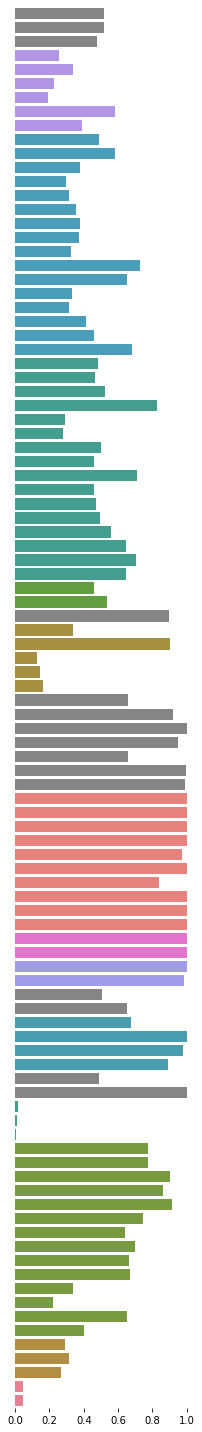

In [16]:
sns.set_palette(['#858585'] + palette)
plt.figure(figsize=(3,20))
prevalence = pd.DataFrame((df_bacteria>0).mean(),columns=['prev'])
prevalence = prevalence.loc[bacteria_order[::-1]]
prevalence['microbe'] = prevalence.index
prevalence['color'] = [color_dict[v] for v in prevalence.microbe]
sns.barplot(data=prevalence, y='microbe', x='prev', hue='color', dodge=False)
#plt.xscale('log')
plt.yticks([])
plt.ylabel('')
plt.xlabel('')
plt.legend().remove()
plt.box(on=None)
plt.tight_layout()
plt.savefig(fig_dir + 'bacteria_prevalence.svg', transparent=True, bbox_inches='tight', format='png', dpi=500)